# Running FEISTY with forcing from CESM

Kristen generated the forcing files, I believe with `/glade/u/home/kristenk/fish-offline/notebooks/proc-cesm-dple-fields.ipynb`.
This notebook doesn't really need to be a notebook, I'm hoping it can be converted to a script instead.
All the parameter settings are handled in the first (non-`import`) cell, where we read in `feisty-config.FOSI_CESM.yml`.
This was run on a casper compute node with 25 GB of memory (the `.compute()` uses a lot of memory on this node, peaked at 21.3 GB before dropping to 10.8).

## Imports

In [1]:
import os

import dask
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import yaml
from dask.distributed import Client
from dask_jobqueue import PBSCluster

import feisty

/glade/work/mlevy/miniconda3/envs/dev-feisty/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


## Configure run

The FEISTY command `config_and_run_from_yaml()` needs a dictionary pointing to forcing streams and initial conditions.
We provide a few `YAML` files containing acceptable configurations.
There are also several parameters controlling how the run is set up.

In [2]:
# Read settings from YAML
feisty_config_file = 'feisty-config.FOSI_CESM.yml'
with open(feisty_config_file) as f:
    feisty_config = yaml.safe_load(f)

In [3]:
print(f'Configuring FEISTY... this is lazy, so ds_out.compute() is needed for computation')

# map_blocks lets us run in parallel over our dask cluster
ds_out = feisty.config_and_run_from_yaml(feisty_config)
ds_out["biomass"]

Configuring FEISTY... this is lazy, so ds_out.compute() is needed for computation
Starting template generation at 11:16:45


<xarray.DataArray 'biomass' (time: 1825, group: 9, X: 85813)>
dask.array<biomass-config_and_run_from_dataset, shape=(1825, 9, 85813), dtype=float64, chunksize=(1825, 9, 4768), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0249-01-01 00:00:00 ... 0253-12-31 00:00:00
  * group    (group) object 'Sf' 'Sp' 'Sd' 'Mf' ... 'Lp' 'Ld' 'benthic_prey'
  * X        (X) float64 320.6 321.7 322.8 194.6 ... 302.3 302.5 302.7 302.9

## Set up Dask cluster

Since the data in `ds` is chunked in `X`, we use a `dask` cluster to configure the parallelization

In [4]:
mem = 10  # GB
dask.config.set({'distributed.dashboard.link': 'proxy/{port}/status'})
# dask.config.set({"distributed.comm.timeouts.tcp": "180s"})
# dask.config.set({"distributed.comm.timeouts.connect": "180s"})
cluster = PBSCluster(
    memory=f'{mem} GB',
    processes=1,
    cores=1,
    queue='casper',
    walltime='1:00:00',
    resource_spec=f'select=1:ncpus=1:mem={mem}GB',
    log_directory='./dask-logs',
)

cluster.scale(feisty_config['num_chunks'])
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: proxy/8787/status,
Dashboard: proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.55:38004,Workers: 0
Dashboard: proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Run the model

In [5]:
%%time
print(f'Configuring and running FEISTY...')
da_out = ds_out["biomass"].compute()

print(da_out.isel(X=55000))

Configuring and running FEISTY...
<xarray.DataArray 'biomass' (time: 1825, group: 9)>
array([[7.07310686e-03, 2.45062010e-06, 3.46184505e-05, ...,
        2.22345104e-02, 2.10854185e-01, 2.03034941e+01],
       [7.22763842e-03, 2.49695222e-06, 3.52085782e-05, ...,
        2.22361375e-02, 2.10855933e-01, 2.03037966e+01],
       [7.37855159e-03, 2.54220186e-06, 3.57847866e-05, ...,
        2.22377659e-02, 2.10857683e-01, 2.03040991e+01],
       ...,
       [1.19329801e-02, 3.51214384e-06, 5.32924868e-05, ...,
        2.14466189e-02, 2.14015603e-01, 2.01582285e+01],
       [1.19969707e-02, 3.52688368e-06, 5.35228782e-05, ...,
        2.14482465e-02, 2.14017509e-01, 2.01585048e+01],
       [1.20603356e-02, 3.54139542e-06, 5.37505456e-05, ...,
        2.14498778e-02, 2.14019422e-01, 2.01587879e+01]])
Coordinates:
  * time     (time) object 0249-01-01 00:00:00 ... 0253-12-31 00:00:00
  * group    (group) object 'Sf' 'Sp' 'Sd' 'Mf' ... 'Lp' 'Ld' 'benthic_prey'
    X        float64 174.3
CPU t

### Plotting

Make a plot of `biomass` over time at a specified column

In [6]:
# Select a column to look at

### FOSI simulations
X = 55000  # looks good compared to matlab (not plotted in this notebook)
# X = 15633  # large error in small classes
# X = 11677  # large error in medium classes
# X = 76989  # large error in benthic

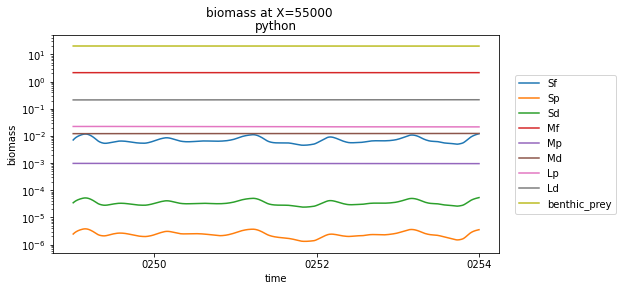

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
for group in ds_out.group.data:
    da_out.sel(group=group).isel(X=X).plot(ax=ax)
ax.set_ylim([5e-7, 50])
ax.set_yscale("log")
ax.set_title("python")
plt.legend(ds_out.group.data, bbox_to_anchor=(1.025, 0.5), loc=6)
fig.suptitle(f"biomass at X={X}");